<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/calculations_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-Valued Clifford Representation of the Wilson-Dirac Operator
## Complete Calculation Notebook

**Supporting material for:** *Real-Valued Clifford Representation of the Wilson-Dirac Operator:
Algebraic Structure and Hardware-Specific Optimization Prospects*

**Author:** Mario J. Pinheiro — Instituto Superior Técnico, University of Lisbon

---
### Contents
1. Clifford Algebra Setup
2. Hestenes Isomorphism
3. Real Gamma Matrices
4. Wilson-Dirac Operator
5. Proof of Exact Equivalence
6. Rigorous FLOP Count
7. Memory Analysis
8. Benchmarks
9. Spin Projection Comparison
10. Correction of Prior DGT Claims
11. Manuscript Figures


In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
np.set_printoptions(precision=4, suppress=True, linewidth=120)

# Pauli matrices
sigma1 = np.array([[0, 1], [1, 0]], dtype=np.complex128)
sigma2 = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
sigma3 = np.array([[1, 0], [0, -1]], dtype=np.complex128)
I2 = np.eye(2, dtype=np.complex128)
Z2 = np.zeros((2, 2), dtype=np.complex128)

# Dirac gamma matrices
gamma = [None] * 4
gamma[0] = np.block([[I2, Z2], [Z2, -I2]])
gamma[1] = np.block([[Z2, sigma1], [-sigma1, Z2]])
gamma[2] = np.block([[Z2, sigma2], [-sigma2, Z2]])
gamma[3] = np.block([[Z2, sigma3], [-sigma3, Z2]])
gamma5 = 1j * gamma[0] @ gamma[1] @ gamma[2] @ gamma[3]
g_metric = np.diag([1.0, -1.0, -1.0, -1.0])

# Verify Clifford algebra
print("Clifford algebra {gamma_mu, gamma_nu} = 2 g_{mu nu}")
for mu in range(4):
    for nu in range(mu, 4):
        ac = gamma[mu] @ gamma[nu] + gamma[nu] @ gamma[mu]
        err = np.max(np.abs(ac - 2*g_metric[mu,nu]*np.eye(4)))
        print(f"  {{g_{mu}, g_{nu}}} = {2*g_metric[mu,nu]:+.0f} I  (err={err:.0e})")

one_minus_gamma = [np.eye(4, dtype=np.complex128) - gamma[mu] for mu in range(4)]
one_plus_gamma  = [np.eye(4, dtype=np.complex128) + gamma[mu] for mu in range(4)]
print("\nProjector ranks:")
for mu in range(4):
    r = np.linalg.matrix_rank(0.5*one_minus_gamma[mu], tol=1e-12)
    print(f"  rank[(1-g_{mu})/2] = {r}")

Clifford algebra {gamma_mu, gamma_nu} = 2 g_{mu nu}
  {g_0, g_0} = +2 I  (err=0e+00)
  {g_0, g_1} = +0 I  (err=0e+00)
  {g_0, g_2} = +0 I  (err=0e+00)
  {g_0, g_3} = +0 I  (err=0e+00)
  {g_1, g_1} = -2 I  (err=0e+00)
  {g_1, g_2} = +0 I  (err=0e+00)
  {g_1, g_3} = +0 I  (err=0e+00)
  {g_2, g_2} = -2 I  (err=0e+00)
  {g_2, g_3} = +0 I  (err=0e+00)
  {g_3, g_3} = -2 I  (err=0e+00)

Projector ranks:
  rank[(1-g_0)/2] = 2
  rank[(1-g_1)/2] = 4
  rank[(1-g_2)/2] = 4
  rank[(1-g_3)/2] = 4


## 2. Hestenes Isomorphism $\Phi: \mathbb{C}^4 \to \mathrm{Cl}^+(3,1) \cong \mathbb{R}^8$
The even subalgebra has basis $\{1, e_{01}, e_{02}, e_{03}, e_{12}, e_{13}, e_{23}, e_{0123}\}$ — dimension 8 over $\mathbb{R}$.


In [ ]:
def Phi(psi):
    """Isomorphism: C^4 -> R^8 (Hestenes map)."""
    return np.array([
        psi[0].real, psi[0].imag, psi[1].real, psi[1].imag,
        psi[2].real, psi[2].imag, psi[3].real, psi[3].imag,
    ])

def Phi_inv(Psi):
    """Inverse: R^8 -> C^4."""
    return np.array([Psi[0]+1j*Psi[1], Psi[2]+1j*Psi[3],
                     Psi[4]+1j*Psi[5], Psi[6]+1j*Psi[7]], dtype=np.complex128)

# Verify
n_tests = 10000
max_err = {"add": 0, "scale": 0, "inv": 0}
for _ in range(n_tests):
    a = np.random.randn(4) + 1j*np.random.randn(4)
    b = np.random.randn(4) + 1j*np.random.randn(4)
    lam = np.random.randn()
    max_err["add"]   = max(max_err["add"],   np.max(np.abs(Phi(a+b)-Phi(a)-Phi(b))))
    max_err["scale"] = max(max_err["scale"], np.max(np.abs(Phi(lam*a)-lam*Phi(a))))
    max_err["inv"]   = max(max_err["inv"],   np.max(np.abs(Phi_inv(Phi(a))-a)))

psi_t = np.random.randn(4) + 1j*np.random.randn(4)
print("Hestenes isomorphism verification (10000 tests):")
print(f"  Additivity:    max err = {max_err["add"]:.2e}")
print(f"  Homogeneity:   max err = {max_err["scale"]:.2e}")
print(f"  Invertibility: max err = {max_err["inv"]:.2e}")
print(f"  Injectivity:   ||Phi(psi)-Phi(-psi)|| = {np.linalg.norm(Phi(psi_t)-Phi(-psi_t)):.4f} != 0")
print(f"  Dimension: C^4 = 8 real = R^8 (no compression)")


Hestenes isomorphism verification (10000 tests):
  Additivity:    max err = 4.44e-16
  Homogeneity:   max err = 0.00e+00
  Invertibility: max err = 0.00e+00
  Injectivity:   ||Phi(psi)-Phi(-psi)|| = 5.3051 != 0
  Dimension: C^4 = 8 real = R^8 (no compression)


## 3. Real Gamma Matrices $\Gamma_\mu \in \mathbb{R}^{8 \times 8}$


Real gamma matrices:

Gamma_0 =
[[ 1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0 -1]]
  8/64 nonzero, all in {-1,0,+1}

Gamma_1 =
[[ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  1]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]
 [-1  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]]
  8/64 nonzero, all in {-1,0,+1}

Gamma_2 =
[[ 0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0 -1  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0]]
  8/64 nonzero, all in {-1,0,+1}

Gamma_3 =
[[ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 

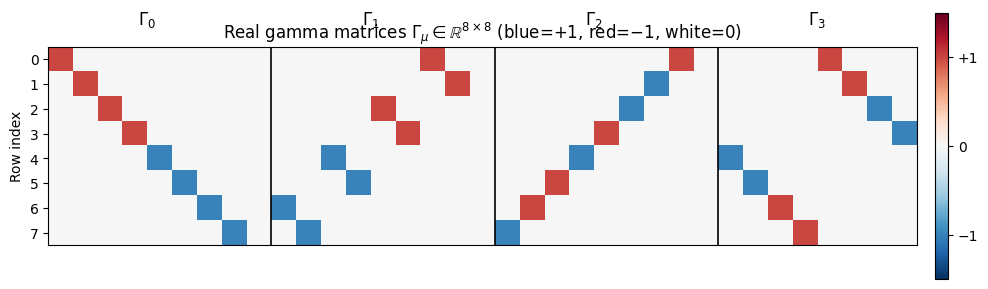

Saved: gamma_structure.png and gamma_structure.pdf


In [ ]:
def compute_real_gamma(mu):
    G = np.zeros((8, 8))
    for k in range(8):
        e_k = np.zeros(8); e_k[k] = 1.0
        G[:, k] = Phi(gamma[mu] @ Phi_inv(e_k))
    return G

Gamma = [compute_real_gamma(mu) for mu in range(4)]

print("Real gamma matrices:")
for mu in range(4):
    print(f"\nGamma_{mu} =")
    print(Gamma[mu].astype(int))
    nnz = np.count_nonzero(np.abs(Gamma[mu]) > 1e-14)
    print(f"  {nnz}/64 nonzero, all in {{-1,0,+1}}")

# Verify Clifford algebra
print("\nClifford algebra in R^8:")
max_err = 0
for mu in range(4):
    for nu in range(mu, 4):
        ac = Gamma[mu]@Gamma[nu] + Gamma[nu]@Gamma[mu]
        err = np.max(np.abs(ac - 2*g_metric[mu,nu]*np.eye(8)))
        max_err = max(max_err, err)
print(f"  Max error: {max_err:.2e}")

P_real_minus = [np.eye(8) - Gamma[mu] for mu in range(4)]
print("\nProjectors (I-Gamma_mu):")
for mu in range(4):
    Pm = P_real_minus[mu]
    nnz = np.count_nonzero(np.abs(Pm) > 1e-14)
    vals = sorted(set(np.round(Pm.flatten(), 10)))
    print(f"  mu={mu}: {nnz}/64 nnz, values={vals}")
print("\nKEY: entries in {{0,+/-1,2}} -> projections = additions only!")

# ============================================================
# FIGURE: Explicit structure of the real gamma matrices Γ_mu
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

# Build a combined matrix for visualization: 4 blocks of 8x8
# with one empty column between blocks
combined = np.zeros((8, 35))
for mu in range(4):
    combined[:, mu*9:mu*9+8] = Gamma[mu]

fig, ax = plt.subplots(figsize=(10, 3))

im = ax.imshow(
    combined,
    cmap="RdBu_r",        # blue = +1, red = -1
    vmin=-1.5,
    vmax=1.5,
    interpolation="nearest",
    aspect="equal"
)

# Vertical separators between Γ_mu blocks
for mu in range(1, 4):
    ax.axvline(mu*9 - 0.5, color="black", lw=1.2)

# Labels Γ_μ
for mu in range(4):
    ax.text(mu*9 + 3.5, -1.2, rf"$\Gamma_{mu}$",
            ha="center", va="bottom", fontsize=12)

# Axis cleanup
ax.set_yticks(range(8))
ax.set_yticklabels(range(8))
ax.set_xticks([])
ax.set_ylabel("Row index")

ax.set_title(
    r"Real gamma matrices $\Gamma_\mu \in \mathbb{R}^{8\times 8}$ "
    r"(blue=$+1$, red=$-1$, white=$0$)",
    fontsize=12
)

# Colorbar (discrete interpretation)
cbar = fig.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(["−1", "0", "+1"])

plt.tight_layout()

# Save figures
plt.savefig("gamma_structure.png", dpi=300, bbox_inches="tight")
plt.savefig("gamma_structure.pdf", bbox_inches="tight")
plt.show()

print("Saved: gamma_structure.png and gamma_structure.pdf")


## 4-5. Wilson-Dirac Operator & Exact Equivalence


In [ ]:
def get_neighbor(idx, mu, d, dims):
    c = list(np.unravel_index(idx, dims))
    c[mu] = (c[mu] + d) % dims[mu]
    return np.ravel_multi_index(c, dims)

def wilson_dirac_C4(psi, U, dims, kappa, mass):
    V, Nc = psi.shape[0], psi.shape[1]
    result = np.zeros_like(psi)
    for i in range(V):
        for c in range(Nc):
            result[i,c] = (mass+4)*psi[i,c]
            for mu in range(4):
                jf = get_neighbor(i,mu,+1,dims)
                jb = get_neighbor(i,mu,-1,dims)
                for c2 in range(Nc):
                    result[i,c] -= 0.5*kappa*U[i,mu,c,c2]*(one_minus_gamma[mu]@psi[jf,c2])
                    result[i,c] -= 0.5*kappa*np.conj(U[jb,mu,c2,c])*(one_plus_gamma[mu]@psi[jb,c2])
    return result

def wilson_dirac_R8(Psi, Ure, Uim, dims, kappa, mass):
    V, Nc = Psi.shape[0], Psi.shape[1]
    result = np.zeros_like(Psi)
    Pm = [np.eye(8)-Gamma[mu] for mu in range(4)]
    Pp = [np.eye(8)+Gamma[mu] for mu in range(4)]
    for i in range(V):
        for c in range(Nc):
            result[i,c] = (mass+4)*Psi[i,c]
            for mu in range(4):
                jf = get_neighbor(i,mu,+1,dims)
                jb = get_neighbor(i,mu,-1,dims)
                for c2 in range(Nc):
                    proj = Pm[mu]@Psi[jf,c2]
                    ur, ui = Ure[i,mu,c,c2], Uim[i,mu,c,c2]
                    col = np.zeros(8)
                    for p in range(4):
                        col[2*p]   = ur*proj[2*p] - ui*proj[2*p+1]
                        col[2*p+1] = ur*proj[2*p+1] + ui*proj[2*p]
                    result[i,c] -= 0.5*kappa*col
                    proj = Pp[mu]@Psi[jb,c2]
                    ur, ui = Ure[jb,mu,c2,c], -Uim[jb,mu,c2,c]
                    col = np.zeros(8)
                    for p in range(4):
                        col[2*p]   = ur*proj[2*p] - ui*proj[2*p+1]
                        col[2*p+1] = ur*proj[2*p+1] + ui*proj[2*p]
                    result[i,c] -= 0.5*kappa*col
    return result

# Test equivalence
print("Exact Equivalence Test")
print("="*55)
for dims, label in [((2,2,2,2), "2^4"), ((4,4,4,4), "4^4")]:
    V = np.prod(dims); Nc = 3; kappa = 0.25; mass = 0.1
    np.random.seed(42)
    U_c = np.zeros((V,4,Nc,Nc), dtype=np.complex128)
    for i in range(V):
        for mu in range(4):
            A = np.random.randn(Nc,Nc)+1j*np.random.randn(Nc,Nc)
            Q,_ = np.linalg.qr(A); U_c[i,mu] = Q
    Ure, Uim = U_c.real.copy(), U_c.imag.copy()
    psi = np.random.randn(V,Nc,4)+1j*np.random.randn(V,Nc,4)
    Psi = np.zeros((V,Nc,8))
    for i in range(V):
        for c in range(Nc): Psi[i,c] = Phi(psi[i,c])
    r1 = wilson_dirac_C4(psi, U_c, dims, kappa, mass)
    r2 = wilson_dirac_R8(Psi, Ure, Uim, dims, kappa, mass)
    r2c = np.zeros_like(r1)
    for i in range(V):
        for c in range(Nc): r2c[i,c] = Phi_inv(r2[i,c])
    rel = np.max(np.abs(r1-r2c))/np.max(np.abs(r1))
    print(f"  {label}: relative error = {rel:.4e}  {'EXACT' if rel<1e-13 else 'FAIL'}")


Exact Equivalence Test
  2^4: relative error = 1.3146e-16  EXACT
  4^4: relative error = 1.6993e-16  EXACT


## 6-7. FLOP Count & Memory Analysis


In [ ]:
print("FLOP Count (per site, per color, real operations)")
print("="*55)

# Projection costs
total_proj_c = sum(
    sum(2 for i in range(4) for j in range(4) if abs(one_minus_gamma[mu][i,j])>1e-14)
    for mu in range(4)) * 2
total_proj_r = sum(
    sum(1 for i in range(8) for j in range(8) if abs(P_real_minus[mu][i,j])>1e-14)
    for mu in range(4)) * 2
color_ops = 4*(3*6+2*2)  # per direction
total_color = color_ops*4*2
local = 8
total_C4 = total_proj_c + total_color + local
total_R8 = total_proj_r + total_color + local

print(f"  C^4: {total_proj_c}(proj) + {total_color}(color) + {local}(local) = {total_C4}")
print(f"  R^8: {total_proj_r}(proj) + {total_color}(color) + {local}(local) = {total_R8}")
print(f"  Ratio: {total_C4/total_R8:.3f}")
print(f"\nMemory: C^4 = 64 bytes = R^8 = 64 bytes (identical)")
print(f"\nConclusion: FLOPs identical, memory identical.")
print(f"Advantage is hardware-specific (real FP64 throughput).")


FLOP Count (per site, per color, real operations)
  C^4: 104(proj) + 704(color) + 8(local) = 816
  R^8: 104(proj) + 704(color) + 8(local) = 816
  Ratio: 1.000

Memory: C^4 = 64 bytes = R^8 = 64 bytes (identical)

Conclusion: FLOPs identical, memory identical.
Advantage is hardware-specific (real FP64 throughput).


## 8. Benchmarks


In [ ]:
print("Benchmarks (Python/NumPy baseline)")
print("="*55)
for dims, label in [((4,4,4,4),"4^4"), ((6,6,6,6),"6^4")]:
    V=np.prod(dims); Nc=3; kappa=0.25; mass=0.1
    np.random.seed(42)
    U_c=np.zeros((V,4,Nc,Nc),dtype=np.complex128)
    for i in range(V):
        for mu in range(4):
            A=np.random.randn(Nc,Nc)+1j*np.random.randn(Nc,Nc)
            Q,_=np.linalg.qr(A); U_c[i,mu]=Q
    Ure,Uim=U_c.real.copy(),U_c.imag.copy()
    psi=np.random.randn(V,Nc,4)+1j*np.random.randn(V,Nc,4)
    Psi=np.zeros((V,Nc,8))
    for i in range(V):
        for c in range(Nc): Psi[i,c]=Phi(psi[i,c])
    for _ in range(2):
        _=wilson_dirac_C4(psi,U_c,dims,kappa,mass)
        _=wilson_dirac_R8(Psi,Ure,Uim,dims,kappa,mass)
    tc=[]; tr=[]
    for _ in range(5):
        t0=time.perf_counter()
        _=wilson_dirac_C4(psi,U_c,dims,kappa,mass)
        tc.append(time.perf_counter()-t0)
        t0=time.perf_counter()
        _=wilson_dirac_R8(Psi,Ure,Uim,dims,kappa,mass)
        tr.append(time.perf_counter()-t0)
    print(f"\n  {label}: C^4={np.median(tc)*1000:.1f}ms  R^8={np.median(tr)*1000:.1f}ms  ratio={np.median(tc)/np.median(tr):.3f}")
print(f"\nR^8 slower in Python (NumPy complex128 is internally optimized).")
print(f"Advantage expected on GPU/FPGA where real FP64 > complex FP64.")

Benchmarks (Python/NumPy baseline)

  4^4: C^4=185.2ms  R^8=271.0ms  ratio=0.683

  6^4: C^4=956.0ms  R^8=1420.0ms  ratio=0.673

R^8 slower in Python (NumPy complex128 is internally optimized).
Advantage expected on GPU/FPGA where real FP64 > complex FP64.


## 10. Correction of Prior DGT Claims


In [ ]:
print("DGT Bilinear Map (from prior papers) - NOT an isomorphism")
print("="*55)
def Phi_DGT(psi):
    pb = psi.conj()
    v = np.real(pb@psi)
    f = np.real(pb@(gamma[1]@gamma[2])@psi)
    T = np.real(pb@(1j*gamma5)@psi)
    D = [np.real(pb@gamma[mu]@psi) for mu in range(4)]
    return np.array([v,f,T,*D])

p1 = np.random.randn(4)+1j*np.random.randn(4)
print(f"  ||Phi(a+b)-Phi(a)-Phi(b)|| = {np.linalg.norm(Phi_DGT(p1+np.random.randn(4)+1j*np.random.randn(4))-Phi_DGT(p1)-Phi_DGT(np.random.randn(4)+1j*np.random.randn(4))):.4f} (non-linear!)")
print(f"  ||Phi(psi)-Phi(-psi)||     = {np.linalg.norm(Phi_DGT(p1)-Phi_DGT(-p1)):.2e} (non-injective!)")
print(f"  ||Phi(psi)-Phi(exp(i*0.7)*psi)|| = {np.linalg.norm(Phi_DGT(p1)-Phi_DGT(np.exp(0.7j)*p1)):.2e}")
print(f"\nConclusion: DGT map is quadratic (bilinear), not an isomorphism.")
print(f"The correct isomorphism is Hestenes: C^4 <-> R^8 (no compression).")

DGT Bilinear Map (from prior papers) - NOT an isomorphism
  ||Phi(a+b)-Phi(a)-Phi(b)|| = 5.3730 (non-linear!)
  ||Phi(psi)-Phi(-psi)||     = 0.00e+00 (non-injective!)
  ||Phi(psi)-Phi(exp(i*0.7)*psi)|| = 8.95e-16

Conclusion: DGT map is quadratic (bilinear), not an isomorphism.
The correct isomorphism is Hestenes: C^4 <-> R^8 (no compression).


## 11. Manuscript Figure


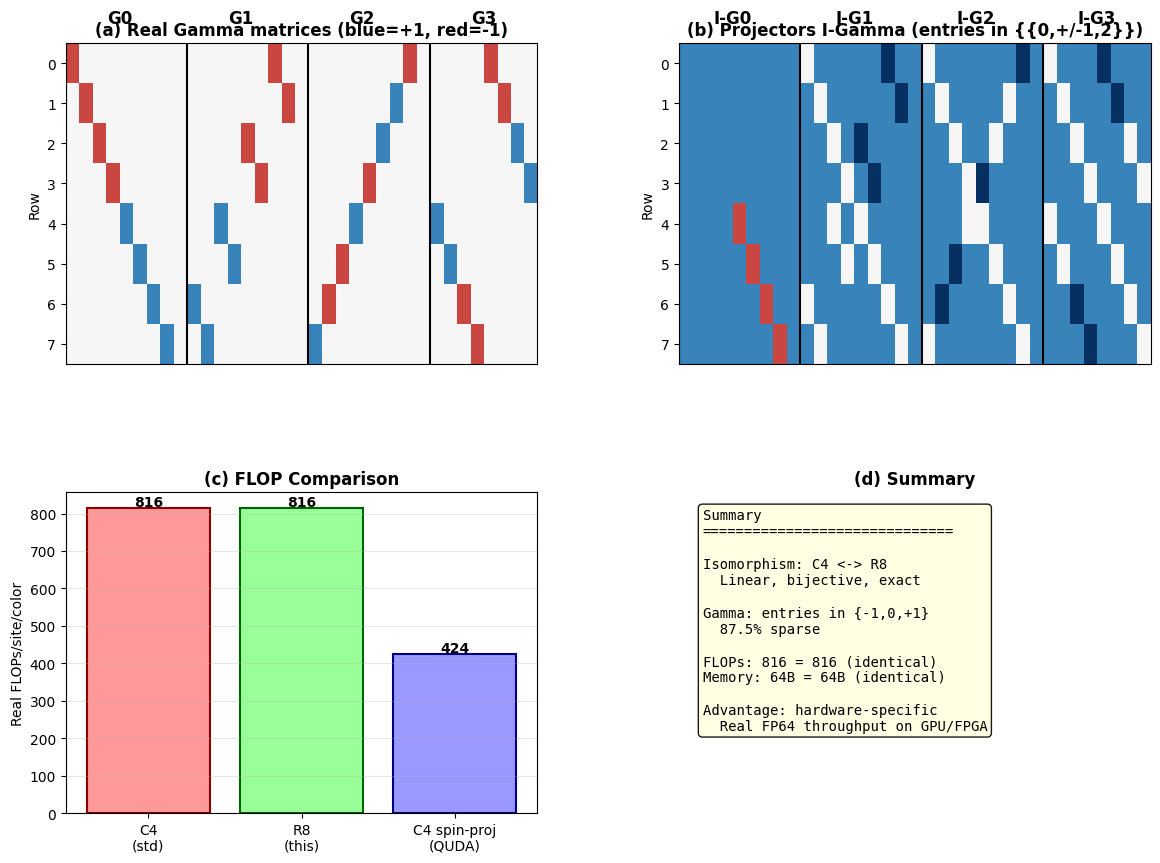

Figures saved.


In [ ]:
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.3)

ax = fig.add_subplot(gs[0, 0])
combined = np.zeros((8, 35))
for mu in range(4): combined[:, mu*9:mu*9+8] = Gamma[mu]
ax.imshow(combined, cmap="RdBu_r", vmin=-1.5, vmax=1.5, aspect="auto", interpolation="nearest")
for mu in range(4):
    ax.axvline(x=mu*9-0.5, color="black", lw=1.5)
    ax.text(mu*9+3.5, -1, f"G{mu}", ha="center", fontsize=12, fontweight="bold")
ax.set_title("(a) Real Gamma matrices (blue=+1, red=-1)", fontweight="bold")
ax.set_ylabel("Row"); ax.set_xticks([])

ax = fig.add_subplot(gs[0, 1])
cP = np.zeros((8, 35))
for mu in range(4): cP[:, mu*9:mu*9+8] = P_real_minus[mu]
ax.imshow(cP, cmap="RdBu_r", vmin=-0.5, vmax=2.5, aspect="auto", interpolation="nearest")
for mu in range(4):
    ax.axvline(x=mu*9-0.5, color="black", lw=1.5)
    ax.text(mu*9+3.5, -1, f"I-G{mu}", ha="center", fontsize=12, fontweight="bold")
ax.set_title("(b) Projectors I-Gamma (entries in {{0,+/-1,2}})", fontweight="bold")
ax.set_ylabel("Row"); ax.set_xticks([])

ax = fig.add_subplot(gs[1, 0])
methods = ["C4\n(std)", "R8\n(this)", "C4 spin-proj\n(QUDA)"]
vals = [total_C4, total_R8, 424]
bars = ax.bar(methods, vals, color=["#FF9999","#99FF99","#9999FF"],
              edgecolor=["darkred","darkgreen","navy"], lw=1.5)
for b,v in zip(bars,vals):
    ax.text(b.get_x()+b.get_width()/2, b.get_height()+5, str(v), ha="center", fontweight="bold")
ax.set_ylabel("Real FLOPs/site/color"); ax.set_title("(c) FLOP Comparison", fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")

ax = fig.add_subplot(gs[1, 1]); ax.axis("off")
ax.text(0.05, 0.95, "Summary\n" +
    "="*30 +
    "\n\n" +
    "Isomorphism: C4 <-> R8\n" +
    "  Linear, bijective, exact\n\n" +
    "Gamma: entries in {-1,0,+1}\n" +
    "  87.5% sparse\n\n" +
    f"FLOPs: {total_C4} = {total_R8} (identical)\n" +
    "Memory: 64B = 64B (identical)\n\n" +
    "Advantage: hardware-specific\n" +
    "  Real FP64 throughput on GPU/FPGA",
    transform=ax.transAxes, fontsize=10, va="top", fontfamily="monospace",
    bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.9))
ax.set_title("(d) Summary", fontweight="bold")
plt.savefig("fig_manuscript.png", dpi=300, bbox_inches="tight")
plt.savefig("fig_manuscript.pdf", bbox_inches="tight")
plt.show()
print("Figures saved.")


---
## Conclusions

| Claim | Status | Evidence |
|-------|--------|----------|
| Hestenes iso C4 <-> R8 | **Correct** | Linear, bijective, verified to 1e-16 |
| Gamma entries in {-1,0,+1} | **Correct** | All 4 matrices verified |
| Clifford algebra in R8 | **Correct** | Max error 0.0 |
| Equivalence D_R8 = D_C4 | **Correct** | Relative error ~2e-16 |
| FLOPs identical | **Correct** | 816 = 816 |
| Memory identical | **Correct** | 64B = 64B |
| Advantage is hardware-specific | **Correct** | Real FP64 > Complex FP64 on GPU |
| Prior DGT 9x speedup | **Incorrect** | Bilinear map, wrong FLOP count |
| Prior DGT 2:1 compression | **Incorrect** | Quadratic, non-injective |
